In [1]:
""" RNN dam flow prediction: stacked RNN """
# import libraries

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# data loading 

rain_data = pd.read_csv('rain_day.csv', encoding='utf-8')
dam_data = pd.read_csv('dam_edit.csv', encoding='utf-8')

In [3]:
""" data making part1 : clip data [2000.01.01 - 2023.12.31]"""
# 2000.01.01 = 9496
rain_data = rain_data[9496:]
dam_data = dam_data[9496:]

data = pd.merge(rain_data, dam_data, on='date', how='inner')
data = data.fillna(0)

rain_cols = list(data)[1:6]
cols = list(data)[1:]

""" data making part2 : making date, dam & rain data """
# date
dates = pd.to_datetime(data['date'])

# dam
dam = data[['dam_t-1']] # To make DataFrame shape, have to use [[ ]] 

# rain
rain = data[rain_cols]

# not date data
data_float = data[cols].astype(float)

In [4]:
rain_cols

['90', '100', '101', '211', '212']

In [5]:
""" data making part3 : using scaler each data(dam & rain) """
# rain scaler
scaler_rain = MinMaxScaler(feature_range = (0,1))
rain_scaled = scaler_rain.fit_transform(rain)

# dam scaler
scaler_dam = MinMaxScaler(feature_range = (0,1))
dam_scaled = scaler_dam.fit_transform(dam)

# put two scaled data to one
data_scaled = np.hstack((rain_scaled, dam_scaled))
data_scaled_df = pd.DataFrame(data_scaled, columns=cols, index=data.index)

In [6]:
""" data making part4 : making sequence to fit the model """
def create_sequences(data, features, target, seq_length):
    X, y = [], []
    for i in range(len(data) - (seq_length)):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# deciding sequence length
seq_len = 7
target = 'dam_t-1'
features = cols

# creating X,y data
X, y = create_sequences(data_scaled_df, cols, target, seq_len)

In [7]:
""" data making part5 : making Train & Test """
# cutting off the dates by seq_len
adjusted_dates = dates[seq_len:]

# deviding data to "Train & Test"
# Train : 2000.01.01 - 2017.12.31
# Test : 2018.01.01 - 2023.12.31
train_mask = (adjusted_dates >= '2000-01-01') & (adjusted_dates <= '2017-12-31')
test_mask = (adjusted_dates >= '2018-01-01') & (adjusted_dates <= '2023-12-31')

# Train
trainX = X[train_mask]
trainY = y[train_mask]
train_dates = adjusted_dates[train_mask]

# Test
testX = X[test_mask]
testY = y[test_mask]
test_dates = adjusted_dates[test_mask]

# original dam data
train_dam = dam[seq_len:seq_len+len(trainY)]
test_dam = dam[len(trainY)+seq_len:]

In [8]:
""" data making part6 : Editing Train & Test shape """
trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

trainY = np.expand_dims(trainY, axis=-1) 
testY = np.expand_dims(testY, axis=-1)    

# print shape
print("Train : ", trainX.shape, trainY.shape)
print("Test : ", testX.shape, testY.shape)
print("Original dam : ", train_dam.shape, test_dam.shape)

Train :  (6568, 7, 6) (6568, 1)
Test :  (2191, 7, 6) (2191, 1)
Original dam :  (6568, 1) (2191, 1)


In [9]:
""" Model """
# RNN model
model = Sequential()
model.add(Flatten(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(64, activation ='relu'))
model.add(Dense(32))
model.add(Dense(1))

model.summary()

C:\Users\wlstj\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer wisth the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [11]:
# Try to load weights
try:
    model.load_weights('7dam_rnn.weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('7dam_rnn.weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

Loaded model weights from disk


C:\Users\wlstj\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
""" Predict value """
train_pred = model.predict(trainX)
test_pred = model.predict(testX)

""" applying inverse scaler : to original value """
# train
train_pred_inv = scaler_dam.inverse_transform(train_pred)
trainY_inv = scaler_dam.inverse_transform(trainY)

# test
test_pred_inv = scaler_dam.inverse_transform(test_pred)
testY_inv = scaler_dam.inverse_transform(testY)

""" if value is smaller than 0, change to 0 """
# Train post-processing 
train_pred_clipped = np.maximum(train_pred_inv, 0)
# Test post-processing
test_pred_clipped = np.maximum(test_pred_inv, 0)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step


In [24]:
# print shape 
print(trainY.shape, train_pred.shape, testY.shape, test_pred.shape)

# print train / test dates
print("Train : ", train_dates.iloc[0])
print("Test : ", test_dates.iloc[0])

(6568, 1) (6568, 1) (2191, 1) (2191, 1)
Train :  2000-01-08 00:00:00
Test :  2018-01-01 00:00:00


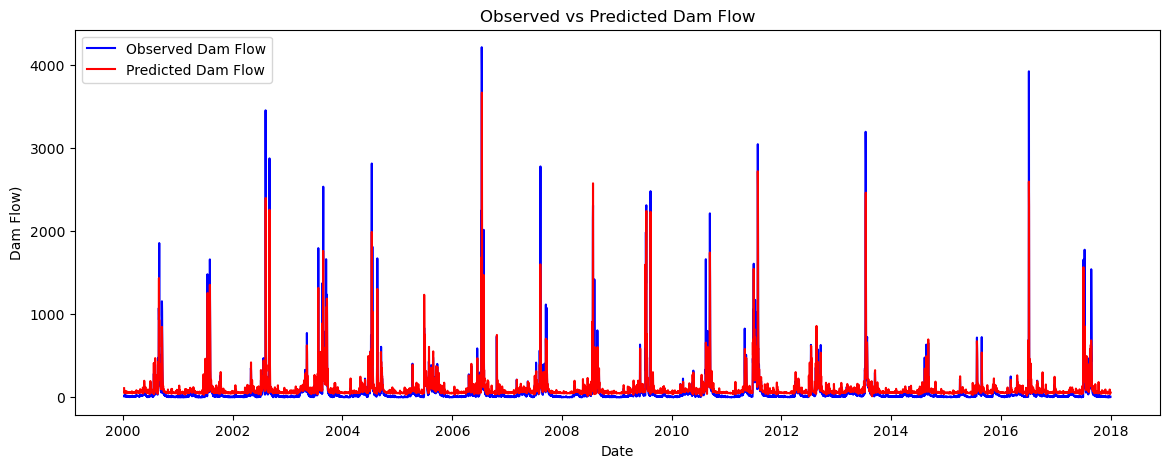

In [14]:
""" Train graph part1"""
# Create the zoomed plot
plt.figure(figsize=(14, 5))

plt.plot(train_dates[:],
         trainY_inv,
         color='blue',
         label='Observed Dam Flow')
plt.plot(train_dates[:],
         train_pred_clipped,
         color='red',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow)')
plt.title('Observed vs Predicted Dam Flow')
plt.legend()
plt.show()

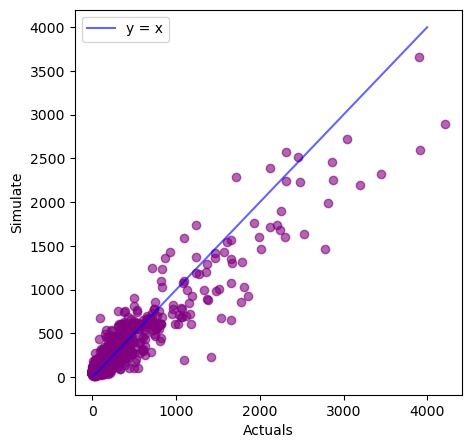

In [18]:
""" Train graph part2 """
# create 1:1 graph (after post-processing, trainY vs trainY_pred)
x = np.arange(0,4000)
y = x

plt.figure(figsize = (5,5))
plt.scatter(trainY_inv[:], train_pred_clipped[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

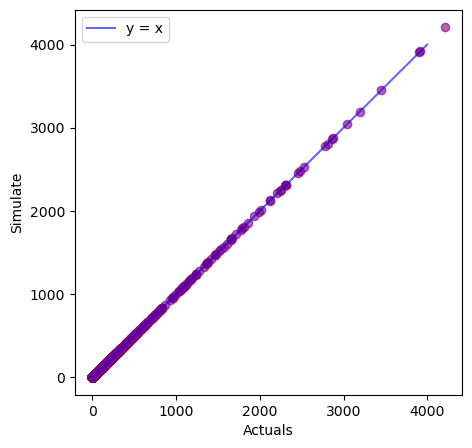

In [19]:
# create 1:1 graph (after post-processing, trainY vs original dam)
x = np.arange(0,4000)
y = x

plt.figure(figsize = (5,5))
plt.scatter(trainY_inv[:], train_dam[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

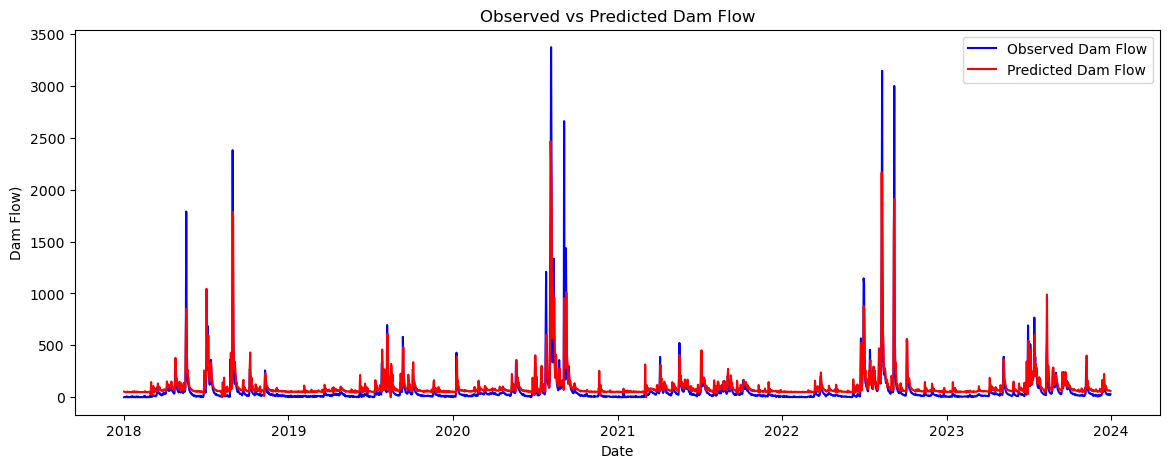

In [26]:
""" Test graph part1"""
# Create the zoomed plot
plt.figure(figsize=(14, 5))

plt.plot(test_dates[:],
         testY_inv,
         color='blue',
         label='Observed Dam Flow')
plt.plot(test_dates[:],
         test_pred_clipped,
         color='red',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow)')
plt.title('Observed vs Predicted Dam Flow')
plt.legend()
plt.show()

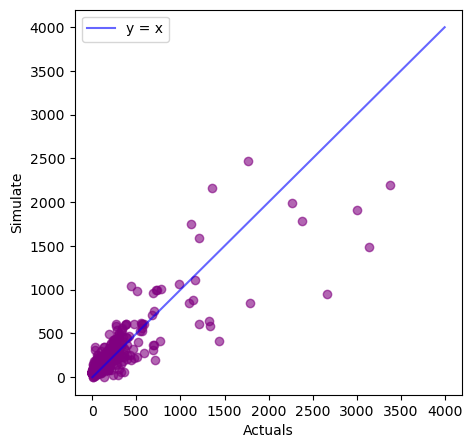

In [27]:
""" Test graph part2 """
# create 1:1 graph (after post-processing, trainY vs trainY_pred)
x = np.arange(0,4000)
y = x

plt.figure(figsize = (5,5))
plt.scatter(testY_inv[:], test_pred_clipped[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [34]:
""" Evaluation code """

# Replace these with your actual data
q_obs = testY_inv[:]
q_sim = test_pred_clipped[:]

#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(q_obs, q_sim))
print('RMSE : %6.2f' %(rmse))

# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(q_obs[:])
for i in range(len(q_obs)):
  num1 = q_obs[i] - q_sim[i]
  num_sum1 += num1**2
  num2 = q_obs[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE  : %6.2f' % nse.item())  # nse 배열에서 값을 추출해 스칼라로 변환

# PBIAS
num_sum1 = 0
for i in range(len(q_obs)):
  num1 = q_obs[i] - q_sim[i]
  num_sum1 += num1
    
# Calculate means
q_obs_mean = np.mean(q_obs)
q_sim_mean = np.mean(q_sim)

pbias = (num_sum1 / np.sum(q_obs[:])) * 100
print('PBIAS: %6.2f' % pbias.item())  # .item()으로 값을 추출

# Calculate numerator and denominators
numerator = np.sum((q_obs - q_obs_mean) * (q_sim - q_sim_mean))
denominator = np.sqrt(np.sum((q_obs - q_obs_mean)**2) * np.sum((q_sim - q_sim_mean)**2))

# Calculate R^2
R_squared = (numerator / denominator)**2

print("R^2  : %6.2f"%R_squared)

RMSE : 102.02
NSE  :   0.73
PBIAS: -58.17
R^2  :   0.77
